<u>Imports</u>

In [1]:
# Standard
import pandas as pd
import requests
from scipy.stats import randint

# Scrapping
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

# Text processing
import re

# Modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

# Visualisation
import matplotlib.pyplot as plt
from pprint import pprint

<u>Scrapping</u>

In [2]:
# Links
url = 'https://www.windguru.cz/112'
executable_path = '/Users/marionchaffaut/chromedriver/chromedriver-mac-x64/chromedriver'

In [3]:
# Initialisation scraping
driver = webdriver.Chrome(executable_path=executable_path)
driver.get(url)
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [4]:
# Save scrapped info into a txt file
text_file = open("forecast.txt", "w")
text_file.write(str(soup.find_all('script')))      
text_file.close()

In [5]:
# Test
# test=driver.find_element(By.XPATH, '//*[@id="tabid_0_0_dates"]/td[2]')
# new_attempt.text

In [6]:
num_prev = 100
names_fig = ['tabid_0_0_dates','tabid_0_0_WINDSPD','tabid_0_0_GUST','tabid_0_0_HTSGW', 'tabid_0_0_PERPW']
names_dir = ['tabid_0_0_SMER','tabid_0_0_DIRPW']
forecast = {}

for name in names_fig:
    temp_list = []  
    for i in range(1, num_prev + 1):
        try: 
            value = driver.find_element(By.XPATH, f'//*[@id="{name}"]/td[{i}]')
            temp_list.append(value.text)
        except Exception as e:
            temp_list.append('na')
    forecast[name] = temp_list  

for name in names_dir:
    temp_list = []  
    for i in range(1, num_prev + 1):
        try:
            value = driver.find_element(By.XPATH, f'//*[@id="{name}"]/td[{i}]/span')
            temp_list.append(value.get_attribute('title'))
        except Exception as e:
            temp_list.append('na')
    forecast[name] = temp_list 

forecast_df=pd.DataFrame(forecast)

In [ ]:
# forecast_df.head()

In [7]:
def extract_angle(direction_string):
    pattern = r'\((\d+)°\)'
    match = re.search(pattern, direction_string)
    if match:
        angle = int(match.group(1))
        return int(angle)
    else:
        return None

In [8]:
forecast_df.tabid_0_0_SMER=forecast_df.tabid_0_0_SMER.apply(extract_angle)
forecast_df.tabid_0_0_DIRPW=forecast_df.tabid_0_0_DIRPW.apply(extract_angle)

<u>Dataset preparation</u>

In [9]:
dataset = pd.read_csv('dataset_rochebonne.csv')

In [10]:
#dataset.head()

In [11]:
#dataset.info()

In [12]:
#dataset.describe()

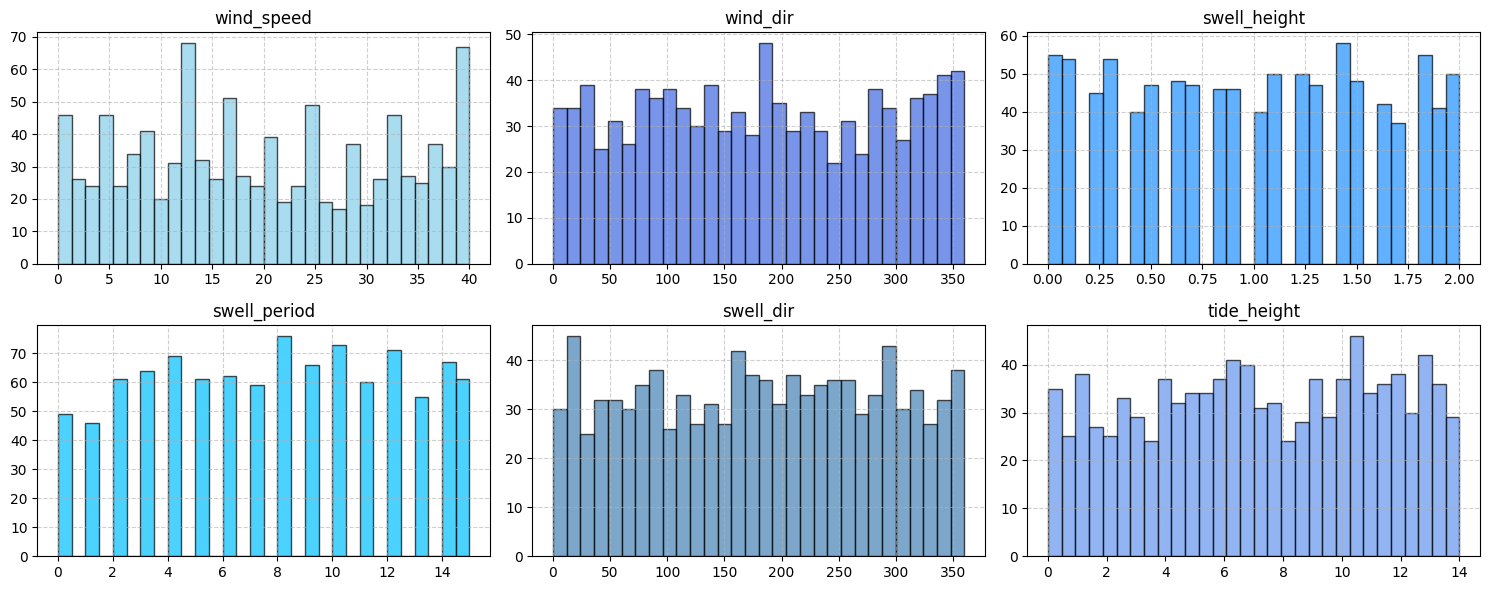

In [13]:
# Plot distribution

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
columns = ['wind_speed', 'wind_dir', 'swell_height', 'swell_period', 'swell_dir', 'tide_height']
colors = ['skyblue', 'royalblue', 'dodgerblue', 'deepskyblue', 'steelblue', 'cornflowerblue']

for ax, col, color in zip(axes.flatten(), columns, colors):
    ax.hist(dataset[col], bins=30, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [14]:
# Split X and y

y = dataset['note']
X = dataset.drop(columns=['note'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

<u>Model</u>

1- Decision Tree

- Control split with min_samples_split
- Control leaves with min_samples_leaf
- Control tree depth with max_depth

In [17]:
clf = DecisionTreeClassifier()

In [18]:
forest = RandomForestRegressor(n_estimators=100)

In [19]:
cv_results = cross_validate(forest, X_train, y_train, scoring = "r2", cv=5)

In [20]:
pd.DataFrame(cv_results)

,fit_time,score_time,test_score
0,0.394808,0.012010,0.755723
1,0.284775,0.010778,0.764965
2,0.346688,0.021451,0.784537
3,0.295041,0.017069,0.783063
4,0.402053,0.011128,0.806993


In [21]:
# Look at parameters used by our current forest

print('Parameters currently in use:\n')
pprint(forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [22]:
forest.fit(X_train, y_train)

RandomForestRegressor()

In [23]:
forest.score(X_test,y_test)

0.8171191671467368

In [26]:
import numpy as np

In [36]:
X_test

,wind_speed,wind_dir,swell_height,swell_period,swell_dir,tide_height
521,3,235,1.8,10,311,5.00
737,12,319,1.6,9,207,12.66
740,14,343,0.5,9,208,9.62
660,14,282,1.1,14,261,13.10
411,16,315,1.6,13,49,9.34
...,...,...,...,...,...,...
408,6,40,0.1,1,78,2.93
332,1,38,0.8,3,166,10.47
208,22,331,1.9,13,157,7.46
613,10,139,1.6,4,12,1.51


In [42]:
y_test

521    3
737    3
740    1
660    3
411    3
      ..
408    0
332    0
208    1
613    0
78     0
Name: note, Length: 200, dtype: int64

In [43]:
y_pred

array([1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0,
       0, 0])

In [41]:
pd.DataFrame(y_test - y_pred)

,note
521,2
737,1
740,0
660,1
411,1
...,...
408,0
332,0
208,1
613,0


In [38]:
y_pred = forest.predict(X_test).astype(int)

In [39]:
from sklearn.metrics import classification_report
target_names = ['rating 0', 'rating 1', 'rating 2', 'rating 3']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    rating 0       0.94      0.96      0.95       153
    rating 1       0.16      0.30      0.21        10
    rating 2       0.04      0.14      0.06         7
    rating 3       0.00      0.00      0.00        30

    accuracy                           0.76       200
   macro avg       0.29      0.35      0.31       200
weighted avg       0.73      0.76      0.74       200



/Users/marionchaffaut/.pyenv/versions/3.10.6/envs/personal-projects/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marionchaffaut/.pyenv/versions/3.10.6/envs/personal-projects/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marionchaffaut/.pyenv/versions/3.10.6/envs/personal-projects/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze